# Days in shelter Classification (For Dogs)

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler , FunctionTransformer,OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector,ColumnTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Getting the data

In [88]:
from From_Shelter_to_Love.data_provisoria_v2 import get_data

#Getting the data

df = get_data()

In [89]:
df.drop(columns = ['Animal ID','age_upon_outcome_years','age_upon_intake_years',\
                   'age_upon_outcome_months','male_or_female_outcome',\
                   'neutered_or_spayed_outcome'], inplace = True)
df.head(2)

,Intake Type,Intake Condition,Animal Type,Breed,Outcome Type,days_in_shelter,age_upon_intake_months,neutered_or_spayed_intake,male_or_female_intake,color
0,Public Assist,Normal,Dog,Mixed,Return to Owner,2.0,72.0,1,1.0,Bicolor
1,Owner Surrender,Normal,Dog,Pure,Transfer,5.0,120.0,1,1.0,Tricolor


In [99]:
df_dogs = df[df['Animal Type'] == 'Dog'].copy()
df_dogs.drop(columns = 'Animal Type', inplace = True)

### Defining Target

In [100]:
def classes(df,column):
    target = []
    for days in df[column]:
        if days <= 7:
            target.append(0)
        else:
            target.append(1)
    df['target'] = target
    return df

classes(df_dogs,"days_in_shelter").head(2)

,Intake Type,Intake Condition,Breed,Outcome Type,days_in_shelter,age_upon_intake_months,neutered_or_spayed_intake,male_or_female_intake,color,target
0,Public Assist,Normal,Mixed,Return to Owner,2.0,72.0,1,1.0,Bicolor,0
1,Owner Surrender,Normal,Pure,Transfer,5.0,120.0,1,1.0,Tricolor,0


In [101]:
X = df_dogs.drop(columns = ['days_in_shelter', 'target', 'Outcome Type']).copy()
y = df_dogs['target'].copy()

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 10)

In [103]:
# Impute then Scale for numerical variables
num_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

# Encode categorical varibles 
cat_transformer = OneHotEncoder(handle_unknown='ignore',sparse=False)

# Apply transformations to desired features
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['int64',"float64"])),
    ('cat_transformer', cat_transformer, make_column_selector(dtype_include=["object"]))])

In [104]:
from sklearn import set_config; set_config(display='diagram')
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ff2fcdf0>),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ff2fceb0>)])

In [105]:
X_train_new = preprocessor.transform(X_train)
X_test_new = preprocessor.transform(X_test)

### Oversample and Undersample

In [106]:
from imblearn.over_sampling import SMOTE
#Create an oversampled training data
smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(X_train_new, y_train)

In [124]:
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(random_state = 101)
X_undersample, y_undersample = under.fit_resample(X_train_new, y_train)

### Grid Search GBClassifier

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier


# Model
gradboost = GradientBoostingClassifier()

#GridSearch

grid_params = {'n_estimators': [25,50,100],
               'max_depth': [5,10,20],
              }

grid_search = GridSearchCV(gradboost, grid_params,
                           scoring = 'f1_macro',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          )

# Fit data to Grid Search
grid_search.fit(X_train_new, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [25, 50, 100]},
             scoring='f1_macro')

In [20]:
# Best score
grid_search.best_score_

0.5829906628171239

In [17]:
# Best Params
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [18]:
# Best estimator
grid_search.best_estimator_

GradientBoostingClassifier(max_depth=10)

### Model

In [26]:
# Model
gradboost = GradientBoostingClassifier(max_depth = 10, n_estimators = 100)

gradboost.fit(X_oversample, y_oversample)

preds = gradboost.predict(X_test_new)

In [27]:
from sklearn.metrics import f1_score

f1_score(y_test,preds,average = 'macro')

0.6078039678616383

### Grid Search Random Forest

In [109]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer

# Model
forest = RandomForestClassifier()

#GridSearch

grid_params = {'n_estimators': [25,50,100],
               'max_depth': [5,10,20],
              }

grid_search = GridSearchCV(forest, grid_params,
                           scoring = 'f1_macro',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          )

# Fit data to Grid Search
grid_search.fit(X_oversample, y_oversample)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [25, 50, 100]},
             scoring='f1_macro')

In [110]:
# Best score
grid_search.best_score_

0.6215677590287887

In [111]:
# Best Params
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [112]:
# Best estimator
grid_search.best_estimator_

RandomForestClassifier(max_depth=10)

In [129]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 10)

forest.fit(X_undersample, y_undersample)

preds = forest.predict(X_test_new)

In [131]:
f1_score(y_test,preds,average = None)

0.620693999816949

### Big interation

In [ ]:
RF = RandomForestClassifier()
param_grid = { 
    'n_estimators': [90,100, 120],
    'criterion' :['gini', 'entropy'],
    'max_depth' : [10,15,20],
    'min_samples_split' : [2,5,8],
    'min_samples_leaf' : [1,2,3],
    'class_weight' : ['balanced','balanced_subsample'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_jobs' : [-1,1 ] 
}

CV_rfc = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='f1_macro')
CV_rfc.fit(X_oversample, y_oversample)
print(f"The f1:{f1_score(y_test, CV_rfc.best_estimator_.predict(X_test_new), average='macro')}")
print(f"CV_rfc.best_params_" ,CV_rfc.best_params_)

In [135]:
rforest = RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 10,\
                                  max_features = 'sqrt', min_samples_leaf = 2,\
                                  min_samples_split = 2, n_estimators = 90, n_jobs = 1)

rforest.fit(X_oversample, y_oversample)

preds = rforest.predict(X_test_new)

f1_score(y_test,preds,average = 'macro')

0.6141620411522406

### XGB Classifier

In [134]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective= 'binary:logistic',
    learning_rate=0.1,
    max_depth=5,
    n_estimators= 180)

xgb_model.fit(X_oversample, y_oversample,verbose=True)
print(f"The f1:{f1_score(y_test, xgb_model.predict(X_test_new), average='macro')}")

/home/gmatos/.pyenv/versions/3.8.6/envs/from_shelter_to_love/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The f1:0.6228879731653673


<AxesSubplot:>

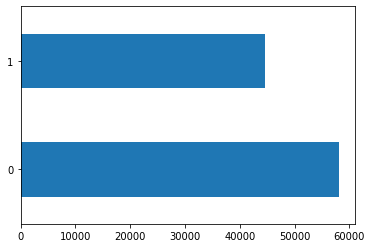

In [123]:
df_dogs["target"].value_counts().plot(kind='barh')

<AxesSubplot:>

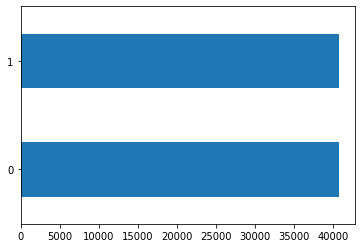

In [122]:
y_oversample.value_counts().plot(kind='barh')

<AxesSubplot:>

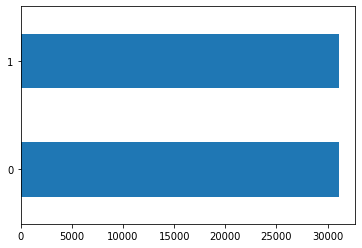

In [125]:
y_undersample.value_counts().plot(kind='barh')